In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#For EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for general use throughout the notebook.
import random
import warnings
import time
%matplotlib inline
from sklearn.model_selection import train_test_split

# to see columns properly
pd.set_option('display.max_colwidth', None)

# for build our model
import tensorflow as tf
from tensorflow.keras.layers import Add, GlobalAvgPool1D, MaxPool1D, Activation, BatchNormalization, Embedding, LSTM, Dense, Bidirectional, Input, SpatialDropout1D, Dropout, Conv1D
from tensorflow.keras import Model
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.activations import relu

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

#!pip install datasets
from datasets import load_dataset

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2022-11-30 11:15:13.937918: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-30 11:15:13.938119: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/kaggle/input/dataset/coltekin.csv
/kaggle/input/dataset/hatc.csv
/kaggle/input/dataset/kaggle.csv
/kaggle/input/ensemble/ensemble.csv


from transformers import logging
logging.set_verbosity_warning()

In [4]:
df = pd.read_csv("/kaggle/input/ensemble/ensemble.csv")
df

,Unnamed: 0,text,label
0,0,Uyanır uyanmaz Hakan Muhafız yeni sezonu izliyorum. Kimse Netflix sevdamızı sorgulamasın.,0
1,1,damla.demir.92 Hiç şaşırmadım 🙄,0
2,2,emrehanmüzik Çok tatlı bir bayan,0
3,3,"ornegin bir dusunun, dogadaki fenomenleri anlayip analiz edebilecek bir bilinc olmazsa, kim cikip “dogada matematik var” diyecek?",0
4,4,bir çoğumuzun hala izlerken kahkaha atarak seyrettiği kibar feyzo filminin şanlıurfa harran'da değil de hatay reyhanlı'ya bağlı harran köyünde çekildiğini öğrenmem olmuştur.,0
...,...,...,...
9995,9995,"Susuyorsak uysal koyun değiliz, vardır birilerinin hatrı.",0
9996,9996,judycfly@ilknur_srm yiyoruz sana ne sanki sen çok temizsin,0
9997,9997,zeynep06gokdemir @elenargnya hadi naş klavye delikanlılığı yapma benim gibi delikanlı ol adres ver gel beyni yarrakla çalışan gurbetçi varoş seni😂😂😂,1
9998,9998,@USER08327 Harika görünüyor Sun cnm oyaragini saatlerce yalayıp yemek istiyorum köküne kadar,1


In [5]:
df = df.drop("Unnamed: 0",axis=1)

In [6]:
train = df[:8000]
val = df[8000:9000]
test = df[9000:]

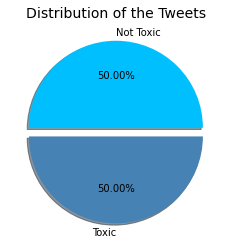

In [7]:
colors=['deepskyblue', 'steelblue']
cmap = plt.cm.prism
plt.pie(train['label'].value_counts(),
            labels=["Not Toxic", "Toxic"],
            autopct='%1.2f%%',
            shadow=True,
            colors=colors,
            explode=(0.05, 0.05))
plt.title('Distribution of the Tweets', fontsize=14)
plt.show()

In [8]:
import os

In [9]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2022-11-30 11:15:22.495690: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-30 11:15:22.499354: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-30 11:15:22.499397: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-30 11:15:22.499425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (74f419aed747): /proc/driver/nvidia/version does not exist
2022-11-30 11:15:22.503297: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [10]:
max_length = 200
batch_size = 128

In [11]:
model_name = "dbmdz/bert-base-turkish-128k-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

In [12]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [13]:
train_encoded = bert_encode(train.text)
val_encoded = bert_encode(val.text)

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, train.label))
    .shuffle(64)
    .batch(batch_size)
)

val_dataset = (
    tf.data.Dataset
   .from_tensor_slices((val_encoded, val.label))
   .shuffle(64)
   .batch(batch_size)
)


In [14]:
def model():
    
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    x = SpatialDropout1D(0.2)(last_hidden_states)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(input_word_ids, outputs)
    
    return model

In [15]:
with strategy.scope():
    model = model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='binary_crossentropy' , optimizer=adam_optimizer, metrics=['accuracy'])
    model.summary()

Downloading:   0%|          | 0.00/386 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Some layers from the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 184345344 
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 768)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           73760     
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               106400    
_________________________________________________________________
dropout_37 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201   

In [16]:
#model.compile için if döncek sadece loss="binary..." değişçek

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]

In [18]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=8,
    validation_data=val_dataset,
    verbose=1,
    callbacks = callbacks)

Epoch 1/8
63/63 [==============================] - 146s 1s/step - loss: 0.6841 - accuracy: 0.5512 - val_loss: 0.5044 - val_accuracy: 0.8060
Epoch 2/8
63/63 [==============================] - 11s 167ms/step - loss: 0.4569 - accuracy: 0.8228 - val_loss: 0.3236 - val_accuracy: 0.8700
Epoch 3/8
63/63 [==============================] - 11s 167ms/step - loss: 0.3314 - accuracy: 0.8760 - val_loss: 0.2822 - val_accuracy: 0.8910
Epoch 4/8
63/63 [==============================] - 11s 168ms/step - loss: 0.2799 - accuracy: 0.8980 - val_loss: 0.2640 - val_accuracy: 0.8970
Epoch 5/8
63/63 [==============================] - 11s 168ms/step - loss: 0.2539 - accuracy: 0.9133 - val_loss: 0.2697 - val_accuracy: 0.8970
Epoch 6/8
63/63 [==============================] - 11s 169ms/step - loss: 0.2201 - accuracy: 0.9288 - val_loss: 0.2655 - val_accuracy: 0.9030
Epoch 7/8
63/63 [==============================] - 11s 168ms/step - loss: 0.2039 - accuracy: 0.9288 - val_loss: 0.2782 - val_accuracy: 0.8990
Epoch 8/

In [19]:
#epoch =1 batchsize=1 olcak

In [20]:
model.save_weights(f'offensive_weights_new_train.h5')

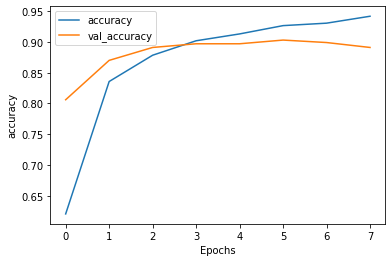

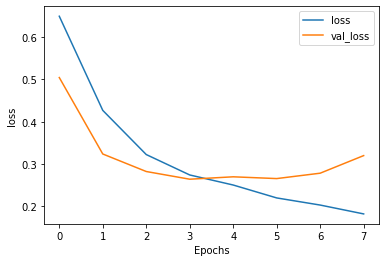

In [21]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [22]:
model.load_weights('/kaggle/working/offensive_weights_new_train.h5')

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 184345344 
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 768)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           73760     
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               106400    
_________________________________________________________________
dropout_37 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201   

In [24]:
from sklearn.metrics import plot_confusion_matrix

In [25]:
test_encoded = bert_encode(test.text)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

In [26]:
pred = model.predict(test_dataset, batch_size=batch_size)
y_pred = tf.cast(tf.round(pred), tf.int32).numpy().flatten()

print('Precision: %.4f' % precision_score(test.label, y_pred))
print('Recall: %.4f' % recall_score(test.label, y_pred))
print('Accuracy: %.4f' % accuracy_score(test.label, y_pred))
print('F1 Score: %.4f' % f1_score(test.label, y_pred))
print(classification_report(test.label, y_pred))

Precision: 0.8550
Recall: 0.9155
Accuracy: 0.8780
F1 Score: 0.8843
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       491
           1       0.86      0.92      0.88       509

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [27]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

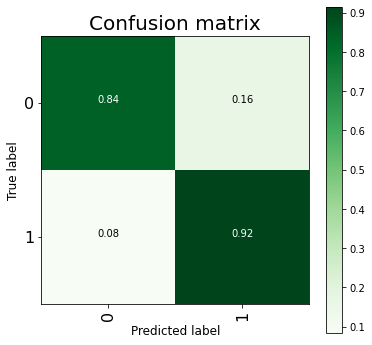

In [28]:
import itertools
cnf_matrix = confusion_matrix(test.label, y_pred)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=train.label.unique(),cmap="Greens", title="Confusion matrix")
plt.show()